In [24]:
import yfinance as yf
import pandas as pd

sp500 = yf.download("^GSPC", start="2005-01-01")
sp500.columns = sp500.columns.get_level_values(0)
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,1202.079956,1217.800049,1200.319946,1211.920044,1510800000
2005-01-04,1188.050049,1205.839966,1185.390015,1202.079956,1721000000
2005-01-05,1183.739990,1192.729980,1183.719971,1188.050049,1738900000
2005-01-06,1187.890015,1191.630005,1183.270020,1183.739990,1569100000
2005-01-07,1186.189941,1192.199951,1182.160034,1187.890015,1477900000


In [25]:
sp500 = sp500.dropna()

In [26]:
import numpy as np
# log returns
sp500["log_return"] = np.log(sp500["Close"] / sp500["Close"].shift(1))

In [27]:
sp500["vol_20"] = sp500["log_return"].rolling(20).std() * np.sqrt(252)
sp500["vol_60"] = sp500["log_return"].rolling(60).std() * np.sqrt(252)

In [28]:
sp500["ma_50"] = sp500["Close"].rolling(50).mean()
sp500["ma_slope"] = sp500["ma_50"].diff(5)

In [29]:
rolling_max = sp500["Close"].cummax()
sp500["drawdown"] = (
    sp500["Close"] - rolling_max
    ) / rolling_max

In [30]:
features = [
    "log_return",
    "vol_20",
    "vol_60",
    "ma_slope",
    "drawdown"
]

data = sp500[features].dropna()

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

Since the objective of this study is structural analysis rather than out-of-sample prediction, clustering was performed on the full historical dataset to identify intrinsic market regimes. No target variables were used, eliminating label leakage concerns.

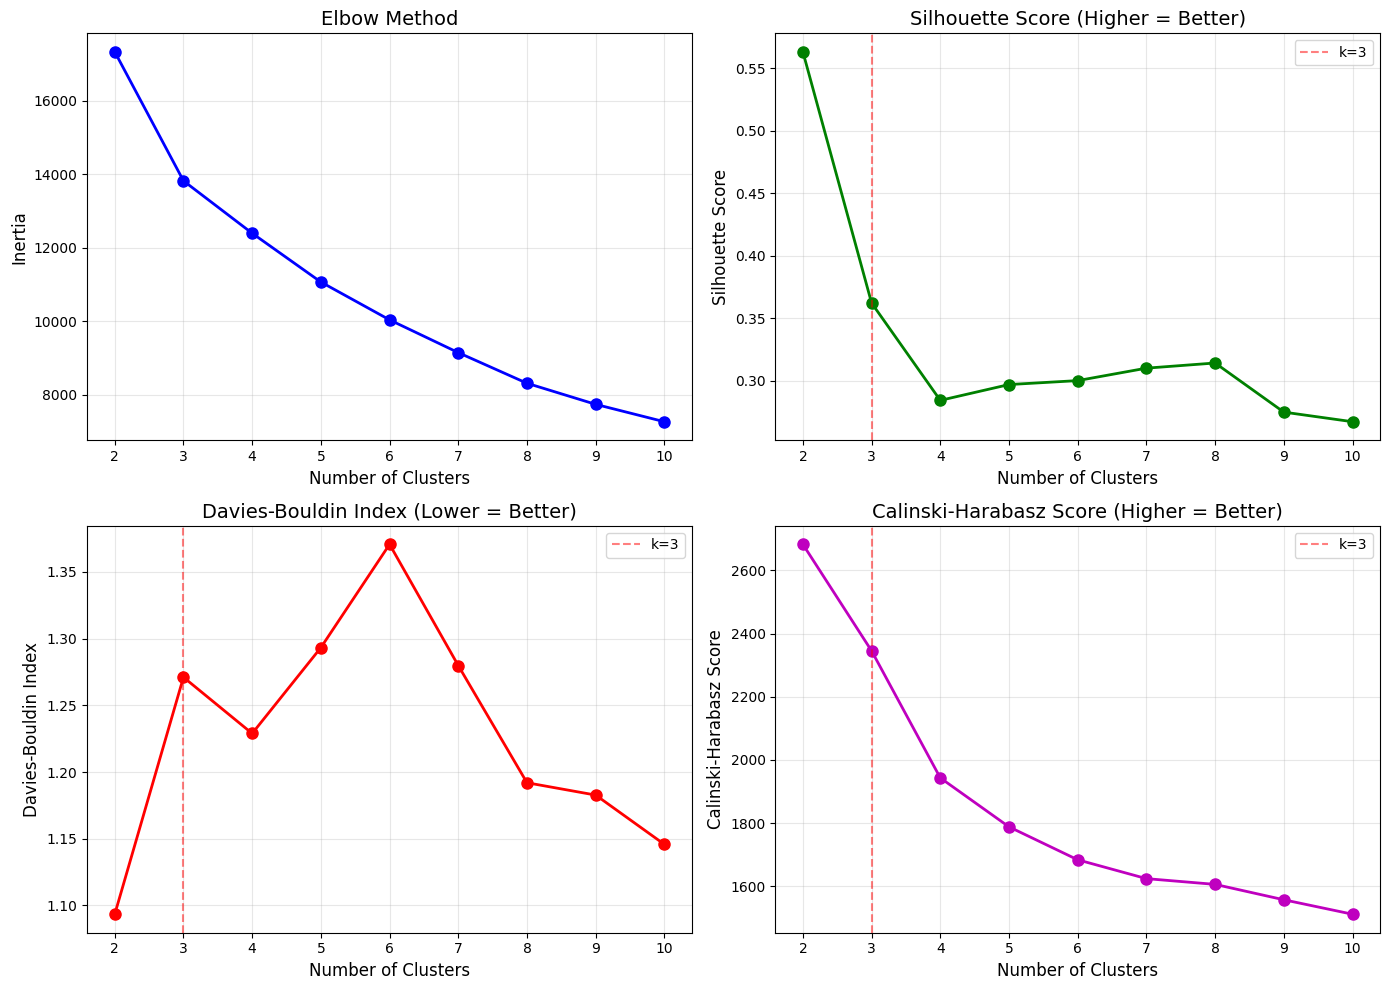

CLUSTER VALIDATION RESULTS
k=2: Silhouette=0.563, Davies-Bouldin=1.093, Calinski=2682.2
k=3: Silhouette=0.362, Davies-Bouldin=1.271, Calinski=2345.1
k=4: Silhouette=0.284, Davies-Bouldin=1.229, Calinski=1943.2
k=5: Silhouette=0.297, Davies-Bouldin=1.293, Calinski=1788.2
k=6: Silhouette=0.300, Davies-Bouldin=1.371, Calinski=1684.0
k=7: Silhouette=0.310, Davies-Bouldin=1.280, Calinski=1624.4
k=8: Silhouette=0.314, Davies-Bouldin=1.192, Calinski=1606.2
k=9: Silhouette=0.275, Davies-Bouldin=1.183, Calinski=1557.5
k=10: Silhouette=0.267, Davies-Bouldin=1.146, Calinski=1511.7

📊 DECISION: Using k=3 clusters
Reason: Balances statistical quality with interpretability
   - k=2: Oversimplified (only crisis vs normal)
   - k=3: Captures stable/transitional/crisis regimes
   - k>3: Overfits, harder to interpret


In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=3, random_state=42)
data["regime"] = kmeans.fit_predict(X_scaled)

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans_temp.fit_predict(X_scaled)
    
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))

# Plot all metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow Method
axes[0, 0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# Silhouette Score (higher is better)
axes[0, 1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=3, color='red', linestyle='--', alpha=0.5, label='k=3')
axes[0, 1].legend()

# Davies-Bouldin Index (lower is better)
axes[1, 0].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=3, color='red', linestyle='--', alpha=0.5, label='k=3')
axes[1, 0].legend()

# Calinski-Harabasz Score (higher is better)
axes[1, 1].plot(K_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score (Higher = Better)', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(x=3, color='red', linestyle='--', alpha=0.5, label='k=3')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print decision matrix
print("="*60)
print("CLUSTER VALIDATION RESULTS")
print("="*60)
for i, k in enumerate(K_range):
    print(f"k={k}: Silhouette={silhouette_scores[i]:.3f}, "
          f"Davies-Bouldin={davies_bouldin_scores[i]:.3f}, "
          f"Calinski={calinski_scores[i]:.1f}")
print("="*60)
print("\n📊 DECISION: Using k=3 clusters")
print("Reason: Balances statistical quality with interpretability")
print("   - k=2: Oversimplified (only crisis vs normal)")
print("   - k=3: Captures stable/transitional/crisis regimes")
print("   - k>3: Overfits, harder to interpret")
print("="*60)

In [33]:
regime_summary = data.groupby("regime").agg({
    "log_return": ["mean", "std"],
    "vol_20": "mean",
    "vol_60": "mean",
    "drawdown": "mean"
})
regime_summary

Price  log_return              vol_20    vol_60  drawdown
             mean       std      mean      mean      mean
regime                                                   
0        0.000613  0.007358  0.110593  0.120363 -0.025951
1       -0.000776  0.034562  0.541367  0.516646 -0.356506
2       -0.000113  0.014170  0.208678  0.209494 -0.183223

In [34]:
regime_summary.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col
    for col in regime_summary.columns
]

regime_summary

,log_return_mean,log_return_std,vol_20_mean,vol_60_mean,drawdown_mean
regime,,,,,
0,0.000613,0.007358,0.110593,0.120363,-0.025951
1,-0.000776,0.034562,0.541367,0.516646,-0.356506
2,-0.000113,0.014170,0.208678,0.209494,-0.183223


In [35]:
regime_summary = regime_summary.rename(columns={
    "log_return_mean": "avg_return",
    "log_return_std": "return_volatility",
    "vol_20_mean": "volatility_20d",
    "vol_60_mean": "volatility_60d",
    "drawdown_mean": "avg_drawdown"
})

regime_summary


,avg_return,return_volatility,volatility_20d,volatility_60d,avg_drawdown
regime,,,,,
0,0.000613,0.007358,0.110593,0.120363,-0.025951
1,-0.000776,0.034562,0.541367,0.516646,-0.356506
2,-0.000113,0.014170,0.208678,0.209494,-0.183223


In [36]:
def label_regime(row):
    if row["avg_drawdown"] > -0.05 and row["volatility_20d"] < 0.2:
        return "Stable / Low Volatility"
    elif row["avg_drawdown"] < -0.25:
        return "Crisis / High Volatility"
    else:
        return "Transitional Market"

regime_summary["regime_type"] = regime_summary.apply(label_regime, axis=1)

regime_summary

,avg_return,return_volatility,volatility_20d,volatility_60d,avg_drawdown,regime_type
regime,,,,,,
0,0.000613,0.007358,0.110593,0.120363,-0.025951,Stable / Low Volatility
1,-0.000776,0.034562,0.541367,0.516646,-0.356506,Crisis / High Volatility
2,-0.000113,0.014170,0.208678,0.209494,-0.183223,Transitional Market


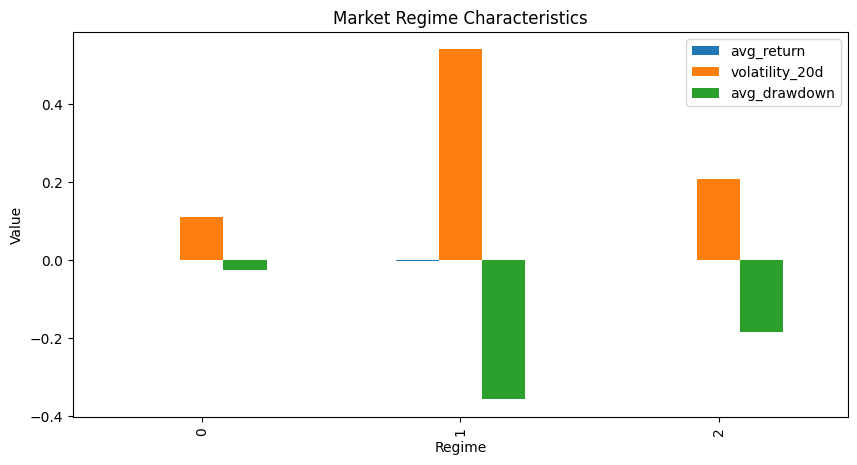

In [37]:
import matplotlib.pyplot as plt

regime_summary[
    ["avg_return", "volatility_20d", "avg_drawdown"]
].plot(kind="bar", figsize=(10, 5))

plt.title("Market Regime Characteristics")
plt.xlabel("Regime")
plt.ylabel("Value")
plt.show()


In [38]:
data["regime"].value_counts(normalize=True)

regime
0    0.661386
2    0.295094
1    0.043520
Name: proportion, dtype: float64

In [39]:
# shift regime to get next-day regime
data["next_regime"] = data["regime"].shift(-1)

# remove last NaN row
transition_data = data.dropna(subset=["next_regime"])

In [40]:
transition_counts = pd.crosstab(
    transition_data["regime"],
    transition_data["next_regime"]
)

transition_counts


next_regime,0.0,1.0,2.0
regime,,,
0,3419,0,45
1,0,223,5
2,45,5,1496


In [41]:
# Replace transition probability calculation with:

# Apply Laplace smoothing to avoid zero probabilities
alpha = 0.1  # Smoothing parameter
smoothed_counts = transition_counts + alpha

transition_probs = smoothed_counts.div(
    smoothed_counts.sum(axis=1),
    axis=0
)

print("Smoothed Transition Probabilities:")
print(transition_probs)

Smoothed Transition Probabilities:
next_regime       0.0       1.0       2.0
regime                                   
0            0.986953  0.000029  0.013019
1            0.000438  0.977223  0.022339
2            0.029166  0.003298  0.967535


BACKTEST RESULTS (2005-2025)
Buy-and-Hold Total Return: 489.02%
Regime-Based Total Return: 603.09%

Buy-and-Hold Max Drawdown: -56.78%
Regime-Based Max Drawdown: -26.12%

Outperformance: 114.06%


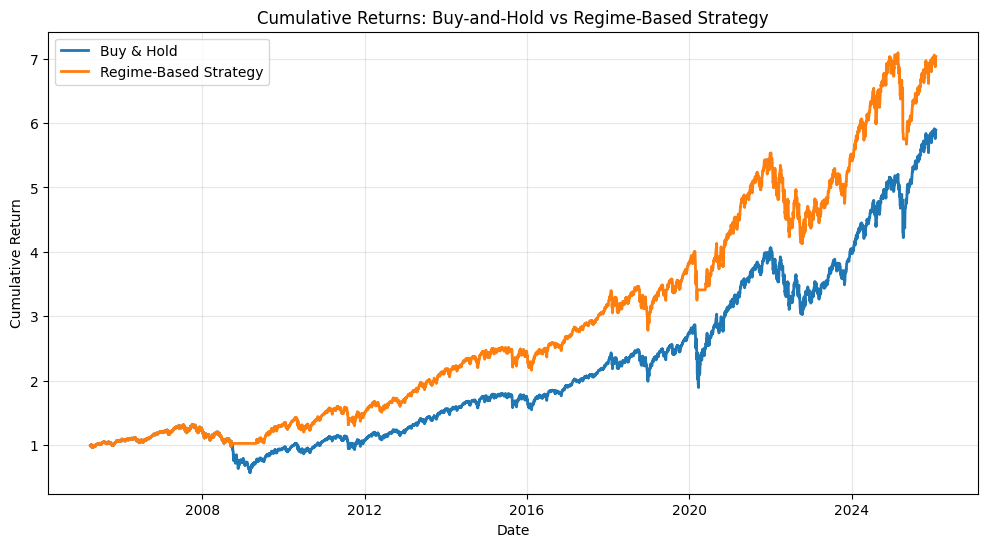

In [42]:
# Backtest: Compare Buy-and-Hold vs Regime-Based Strategy

# Merge regime data with original sp500 data
sp500_with_regime = sp500.join(data[['regime']], how='inner')

# Calculate daily returns
sp500_with_regime['daily_return'] = sp500_with_regime['Close'].pct_change()

# Strategy: Exit stocks during crisis regime (regime 1), hold cash (0% return)
sp500_with_regime['strategy_return'] = sp500_with_regime['daily_return'].copy()
sp500_with_regime.loc[sp500_with_regime['regime'] == 1, 'strategy_return'] = 0

# Calculate cumulative returns
sp500_with_regime['buy_hold_cum'] = (1 + sp500_with_regime['daily_return']).cumprod()
sp500_with_regime['strategy_cum'] = (1 + sp500_with_regime['strategy_return']).cumprod()

# Performance metrics
total_return_bh = (sp500_with_regime['buy_hold_cum'].iloc[-1] - 1) * 100
total_return_strategy = (sp500_with_regime['strategy_cum'].iloc[-1] - 1) * 100

max_dd_bh = sp500_with_regime['buy_hold_cum'].div(sp500_with_regime['buy_hold_cum'].cummax()).sub(1).min() * 100
max_dd_strategy = sp500_with_regime['strategy_cum'].div(sp500_with_regime['strategy_cum'].cummax()).sub(1).min() * 100

# Print results
print("="*50)
print("BACKTEST RESULTS (2005-2025)")
print("="*50)
print(f"Buy-and-Hold Total Return: {total_return_bh:.2f}%")
print(f"Regime-Based Total Return: {total_return_strategy:.2f}%")
print(f"\nBuy-and-Hold Max Drawdown: {max_dd_bh:.2f}%")
print(f"Regime-Based Max Drawdown: {max_dd_strategy:.2f}%")
print(f"\nOutperformance: {total_return_strategy - total_return_bh:.2f}%")
print("="*50)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(sp500_with_regime.index, sp500_with_regime['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(sp500_with_regime.index, sp500_with_regime['strategy_cum'], label='Regime-Based Strategy', linewidth=2)
plt.title('Cumulative Returns: Buy-and-Hold vs Regime-Based Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
# Add new cell
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Compare K-Means vs Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
data['regime_gmm'] = gmm.fit_predict(X_scaled)

# Evaluate both
kmeans_silhouette = silhouette_score(X_scaled, data['regime'])
gmm_silhouette = silhouette_score(X_scaled, data['regime_gmm'])

print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
print(f"GMM Silhouette Score: {gmm_silhouette:.3f}")

# Use the better model
if gmm_silhouette > kmeans_silhouette:
    print("\nGMM performs better! Using GMM regimes.")
    data['regime'] = data['regime_gmm']

K-Means Silhouette Score: 0.363
GMM Silhouette Score: 0.209
